# 4. Desarrollo de modelos II. Ensambles.

Este cuaderno intentará mejorar los resultados del cuaderno anterior utilizando distintas formas de combinarlos. A esto se denomina 'Ensambles'. 
El procedimiento está organizado en las siguientes secciones (las primeras son casi idénticas al cuaderno anterior, con diferencias menores de uso de API de SKLearn para cálculo de métricas):

1. Carga de dataset con distintos preprocesamientos.
2. Desarrollo y entrenamiento de modelos de ensamble utilizando los modelos desarrollados en el cuaderno anterior con SKLearn y [ML-Ensamble](https://mlens.readthedocs.io/en/0.1.x/)
3. Comparación de resultados y conclusiones.

## 4.1 Carga de dataset con distintos preprocesamientos

En el cuaderno anterior se generaron los siguientes archivos CSV:
- **creditcard_train.csv**: partición de dataset original para entrenamiento con modificación de columnas (row_id y tiempo).
- **creditcard_test.csv**: partición de dataset original para evaluación con modificación de columnas (row_id y tiempo).
- **creditcard_downsampled.csv**: dataset balanceado por método de undersampling.
- **creditcard_train_oversampled_adasyn.csv**: partición de entrenamiento balanceado por upsampling (ADASYN).
- **creditcard_train_oversampled_smote.csv**: partición de entrenamiento balanceado por upsampling (SMOTE).
- **creditcard_train_oversampled_blsmote.csv**: partición de entrenamiento balanceado por upsampling (Borderline SMOTE).

En esta sección se los carga y particiona para poder utilizarlos en el entrenamiento de modelos.

In [1]:
TMP_PATH = "./tmp/" # Path temporal usado para imágenes generadas, archivos intermedios, etc.
MODELS_PATH = "/models/"

In [2]:
import pandas as pd
import numpy as np
import joblib
import json
import matplotlib.pyplot as plt

In [3]:
DATASET_PATH = '/data/credit_fraud/'

Se utilizará un diccionario para facilitar la selección de un dataset durante la configuración de los entrenamientos .

In [4]:
train_ds_dict = {
    "downsampled": pd.read_csv(DATASET_PATH+"creditcard_downsampled.csv"),
    "os_adasyn": pd.read_csv(DATASET_PATH+"creditcard_train_oversampled_adasyn.csv"),
    "os_blsmote": pd.read_csv(DATASET_PATH+"creditcard_train_oversampled_blsmote.csv"),
    "os_smote": pd.read_csv(DATASET_PATH+"creditcard_train_oversampled_smote.csv")
}

Dataset de evaluación.

In [5]:
test_df = pd.read_csv(DATASET_PATH+"creditcard_test.csv")

Selección de columnas de features.

In [6]:
non_feature_cols = ['Unnamed: 0','time','row_id','class']
feature_cols = [x for x in test_df.columns if x not in non_feature_cols]
feature_cols

['v1',
 'v2',
 'v3',
 'v4',
 'v5',
 'v6',
 'v7',
 'v8',
 'v9',
 'v10',
 'v11',
 'v12',
 'v13',
 'v14',
 'v15',
 'v16',
 'v17',
 'v18',
 'v19',
 'v20',
 'v21',
 'v22',
 'v23',
 'v24',
 'v25',
 'v26',
 'v27',
 'v28',
 'amount']

Para los datos a los cuáles se ha aplicado undersampling es necesario particionar en train y split. Como el undersampling se hizo eliminando muestras de la clase mayoritaria, en este caso los datos ya están balanceados y se puede aplicar cualquier métrica sobre el test set.

In [7]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.3

X_train_downsampled,X_test_downsampled,y_train_downsampled,y_test_downsampled = train_test_split(
    train_ds_dict['downsampled'][feature_cols],
    train_ds_dict['downsampled']['class'],
    test_size=TEST_SIZE, random_state=42)

In [8]:
X_train_downsampled.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount
398,-0.112195,0.401013,-1.368654,1.325461,1.812514,-1.655252,1.887604,-0.971989,1.356304,0.874950,...,-0.038966,0.164669,1.618395,0.465093,-0.081923,-1.065862,-0.418760,0.439829,-0.040883,45.00
523,-4.727713,3.044469,-5.598354,5.928191,-2.190770,-1.529323,-4.487422,0.916392,-1.307010,-4.138891,...,-0.207759,0.650988,0.254983,0.628843,-0.238128,-0.671332,-0.033590,-1.331777,0.705698,30.39
809,-26.457745,16.497472,-30.177317,8.904157,-17.892600,-1.227904,-31.197329,-11.438920,-9.462573,-22.187089,...,2.812241,-8.755698,3.460893,0.896538,0.254836,-0.738097,-0.966564,-7.263482,-1.324884,1.00


In [9]:
X_test_downsampled.head(3)

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,...,v20,v21,v22,v23,v24,v25,v26,v27,v28,amount
613,-10.645800,5.918307,-11.671043,8.807369,-7.975501,-3.586806,-13.616797,6.428169,-7.368451,-12.888158,...,-0.046170,2.571970,0.206809,-1.667801,0.558419,-0.027898,0.354254,0.273329,-0.152908,0.00
451,-2.218541,1.211222,-0.326345,0.763670,-0.741354,1.914052,0.943716,-5.294108,1.432909,2.441081,...,-1.347714,2.981848,-1.551763,0.922801,0.722661,-1.848255,-0.816578,-0.757258,-1.143818,282.98
731,-4.198735,0.194121,-3.917586,3.920748,-1.875486,-2.118933,-3.614445,1.687884,-2.189871,-4.684233,...,1.003350,0.801312,-0.183001,-0.440387,0.292539,-0.144967,-0.251744,1.249414,-0.131525,238.90


In [10]:
y_train_downsampled.value_counts(),y_test_downsampled.value_counts()

(1    346
 0    342
 Name: class, dtype: int64,
 0    150
 1    146
 Name: class, dtype: int64)

Para los datos con oversampling no es necesario realizar esta partición pues ya se ha hecho previamente (y sólo se han incorporado muestras a la partición de train). No obstante, los datos del test no han sido balanceados, por lo tanto deben balancearse o seleccionar una métrica apropiada.

In [11]:
def choose_dataset(resampling_strategy):
    if resampling_strategy == 'undersampling':        
        X_train = X_train_downsampled
        y_train = y_train_downsampled
        X_test = X_test_downsampled        
        y_test = y_test_downsampled        
    else:
        X_train = train_ds_dict[resampling_strategy][feature_cols]
        y_train = train_ds_dict[resampling_strategy]['class']
        X_test = test_df[feature_cols]
        y_test = test_df['class']
    return X_train, y_train, X_test, y_test

# Ejemplo:
X_train, y_train, X_test, y_test= choose_dataset('undersampling') # args['resampling_strategy']

## 4.2 Entrenamiento de modelos

En esta sección se procederá a entrenar modelos de ensamble a partir de los modelos desarrollados en el cuaderno anterior.

### 4.2.1 Carga de modelos desarrollados anteriormente

Se cargarán los modelos desarrollados en el cuaderno anterior.

In [12]:
df_models = pd.read_csv(MODELS_PATH+"model_summary.csv",skiprows=1, names=[
    "name", "accuracy", "precision", "recall", "auc", "f1-score", "description"
]).set_index('name')
df_models

,accuracy,precision,recall,auc,f1-score,description
name,,,,,,
base,0.493243,0.493243,1.000000,0.500000,0.660633,Modelo base
DecisionTree,0.902027,0.887417,0.917808,0.965845,0.902357,DecisionTree
RandomForest,0.925676,0.969697,0.876712,0.976438,0.920863,RandomForest
LogisticRegression,0.908784,0.921986,0.890411,0.964087,0.905923,LogisticRegression
SVM,0.922297,0.976744,0.863014,0.973333,0.916364,SVM
MLP,0.905405,0.909722,0.897260,0.976210,0.903448,MLP
xgboost,0.925676,0.992063,0.856164,0.979452,0.919118,xgboost
NearestNeighbors,0.905405,0.953846,0.849315,0.961187,0.898551,NearestNeighbors


Como el modelo baseline no es de interés para los ensambles, se descartará.

In [13]:
df_models.drop('base',inplace=True)
df_models

,accuracy,precision,recall,auc,f1-score,description
name,,,,,,
DecisionTree,0.902027,0.887417,0.917808,0.965845,0.902357,DecisionTree
RandomForest,0.925676,0.969697,0.876712,0.976438,0.920863,RandomForest
LogisticRegression,0.908784,0.921986,0.890411,0.964087,0.905923,LogisticRegression
SVM,0.922297,0.976744,0.863014,0.973333,0.916364,SVM
MLP,0.905405,0.909722,0.897260,0.976210,0.903448,MLP
xgboost,0.925676,0.992063,0.856164,0.979452,0.919118,xgboost
NearestNeighbors,0.905405,0.953846,0.849315,0.961187,0.898551,NearestNeighbors


In [14]:
df_models.loc[:,'model'] = df_models.loc[:,:].apply(lambda row : joblib.load(MODELS_PATH+row.name+".pkl"), axis = 1) 
df_models.loc[:,'model_params'] = df_models.loc[:,:].apply(lambda row : json.load(open(MODELS_PATH+row.name+".json")), axis = 1) 
df_models.sort_values(by="auc", ascending=False)

,accuracy,precision,recall,auc,f1-score,description,model,model_params
name,,,,,,,,
xgboost,0.925676,0.992063,0.856164,0.979452,0.919118,xgboost,"XGBClassifier(base_score=0.5, booster='gbtree'...","{'boosting': 'gblinear', 'tree_method': 'appro..."
RandomForest,0.925676,0.969697,0.876712,0.976438,0.920863,RandomForest,"(DecisionTreeClassifier(max_features='auto', m...","{'min_samples_leaf': 13, 'min_samples_split': ..."
MLP,0.905405,0.909722,0.897260,0.976210,0.903448,MLP,"MLPClassifier(alpha=3.8925818075083096e-05,\n ...","{'solver': 'lbfgs', 'n_layers': 5, 'learning_r..."
SVM,0.922297,0.976744,0.863014,0.973333,0.916364,SVM,"SVC(C=17.48365748417831, max_iter=1000, probab...","{'C': 17.48365748417831, 'kernel': 'rbf', 'gam..."
DecisionTree,0.902027,0.887417,0.917808,0.965845,0.902357,DecisionTree,"DecisionTreeClassifier(max_depth=22, min_sampl...","{'criterion': 'gini', 'max_depth': 22, 'min_sa..."
LogisticRegression,0.908784,0.921986,0.890411,0.964087,0.905923,LogisticRegression,"LogisticRegression(max_iter=1659, penalty='non...","{'solver': 'newton-cg', 'n_layers': 1659, 'pen..."
NearestNeighbors,0.905405,0.953846,0.849315,0.961187,0.898551,NearestNeighbors,"KNeighborsClassifier(algorithm='kd_tree', leaf...","{'n_neighbors': 10, 'weights': 'distance', 'al..."


### 4.2.2 Criterio de evaluación

Se mantiene el mismo criterio de evaluación usado anteriormente. Para todos los modelos se obtendrán métricas relevantes para la clasificación binaria:

- **Accuracy**: Ratio de observaciones correctas sobre total de observaciones. $\frac{TP+TN}{TP+FP+FN+TN}$. Dado que se ha aplicado undersampling a los datos para balancearlos, esta métrica puede usarse. De mantenerse el dataset imbalanceado esta métrica puede dar una interpretación errónea del desempeño del algoritmo.
- **Precision**: $\frac{TP}{TP+FP}$. Se relaciona con una baja tasa de falsos positivos.
- **Recall**: $\frac{TP}{TP+FN}$. Mide la cantidad de predicciones correctas para cada clase. De todos los casos de fraude, ¿cuántos fueron correctamente identificados?.
- **Curva ROC**: La curva ROC indica qué tan capaz es un modelo de distinguir clases relacionando la tasa de falsos positivos con la tasa de verdaderos positivos.
- **AUC**: el Área bajo la Curva ROC es un indicador de qué tan bueno es un clasificador independientemente del umbral de clasificación elegido.
- **f1-score**: Promedio entre Precision y Recall. $2\frac{Recall x Precision}{Recall + Precision}$
- **Matriz de Confusión:**: es una forma de visualizar para cada clase TP,TN,FP y FN.

Siendo:
- TP (True Positives): casos de Fraude identificados como Fraude.
- TN (True Negatives): casos de No fraude identificados como No Fraude.
- FP (False Positives): casos de No Fraude identificados como Fraude.
- FN (False Negatives): casos de Fraude identificados como No Fraude.

Se provee una función que realiza un reporte con las anteriores métricas para un modelo y un dataset de evaluación. A diferencia del cuaderno anterior, se utiliza *confusion_matrix* y *ConfusionMatrixDisplay* porque los clasificadores de [ML-Ensamble](https://mlens.readthedocs.io/en/0.1.x/) no cumplen exactamente con la API de los de SKLearn.

In [15]:
from sklearn import metrics 
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

def model_evaluation_report(model,y_test,y_pred,y_pred_prob,description):
    accuracy = metrics.accuracy_score(y_test, y_pred.round(), normalize=True)
    precision = metrics.precision_score(y_test, y_pred,zero_division=False)
    recall = metrics.recall_score(y_test, y_pred)
        
    #fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 3]))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1])
    auc = metrics.auc(fpr, tpr)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    fig, axes = plt.subplots(1,2,figsize=(20,10))
    cm = confusion_matrix(y_test, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['No Fraude','Fraude'])
    disp = disp.plot(ax=axes[0])
    
    axes[0].set_title("Confusion Matrix")
    axes[0].set_xlabel('Predicción')
    axes[0].set_ylabel('Etiqueta real')
    #plt.show()
    
    #plt.figure()
    axes[1].plot(fpr, tpr)
    axes[1].grid(which='Both')
    axes[1].set_title("Curva ROC")
    axes[1].set_xlabel('Tasa de falsos positivos (1 - Especificidad)')
    axes[1].set_ylabel('Tasa de positivos (Sensibilidad)')
    plt.show()   
            
    print("AUC:", auc )
    print("Accuracy:", accuracy )
    print("Precision:", precision )
    print("Recall:", recall)
    print("f1-score: ", f1_score)
    
    model_summary={
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "auc": auc,
        "f1-score": f1_score,
        "description": description
    }
    return model_summary


Ejemplo para el clasificador de base (Dummy).

In [16]:
X_train, y_train, X_test, y_test= choose_dataset('undersampling')

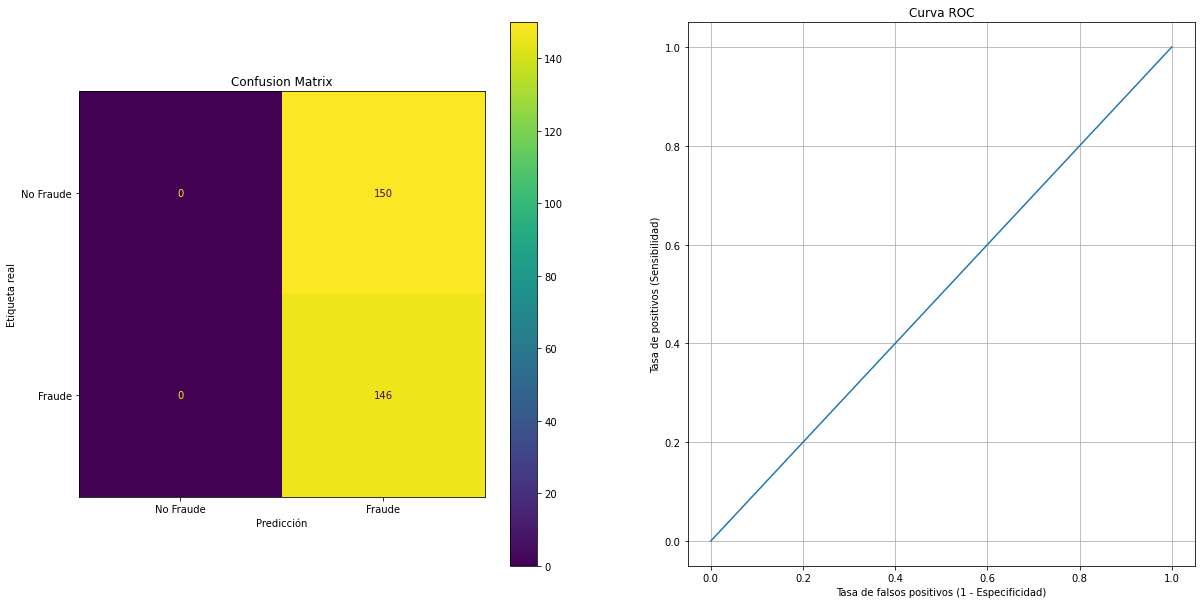

AUC: 0.5
Accuracy: 0.49324324324324326
Precision: 0.49324324324324326
Recall: 1.0
f1-score:  0.6606334841628959


In [17]:
from sklearn.dummy import DummyClassifier 

model = DummyClassifier(strategy='most_frequent')
model = model.fit(X_train,y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)

model_name = "base"
description = "Modelo base"
model_metrics = model_evaluation_report(model,y_test,y_pred,y_pred_prob,description)

### 4.2.3 Entrenamiento de modelos

In [18]:
# Para futura tabla comparativa
model_metrics_list = {}

Lista con todos los estimadores anteriores.

In [19]:
estimators = []
for idx, row in df_models.iterrows():
    estimators.append((row.name,row['model']))
estimators    

[('DecisionTree', DecisionTreeClassifier(max_depth=22, min_samples_leaf=40)),
 ('RandomForest',
  RandomForestClassifier(min_samples_leaf=13, min_samples_split=6,
                         n_estimators=158)),
 ('LogisticRegression',
  LogisticRegression(max_iter=1659, penalty='none', solver='newton-cg')),
 ('SVM', SVC(C=17.48365748417831, max_iter=1000, probability=True)),
 ('MLP',
  MLPClassifier(alpha=3.8925818075083096e-05,
                hidden_layer_sizes=[15, 8, 31, 12, 43], max_iter=2000,
                solver='lbfgs')),
 ('xgboost',
  XGBClassifier(base_score=0.5, booster='gbtree', boosting='gblinear',
                colsample_bylevel=0.67, colsample_bynode=0.35,
                colsample_bytree=0.51, eval_metric='rmse', gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints='',
                learning_rate=0.020262168850806294, max_delta_step=0,
                max_depth=14, min_child_weight=2, missing=nan,
                monotone_constraints='

#### 4.2.3.1 Votador blando (SKLearn)

El primer ensamble será un votador blando en el que todos los modelos devuelven la probabilidad de fraude y la respuesta final será el promedio de todos los votadores.

In [ ]:
from sklearn.ensemble import VotingClassifier

ensemble_name = "VotingSoft"

ensemble_model = VotingClassifier(estimators, voting='soft')
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)
y_pred_prob = ensemble_model.predict_proba(X_test)

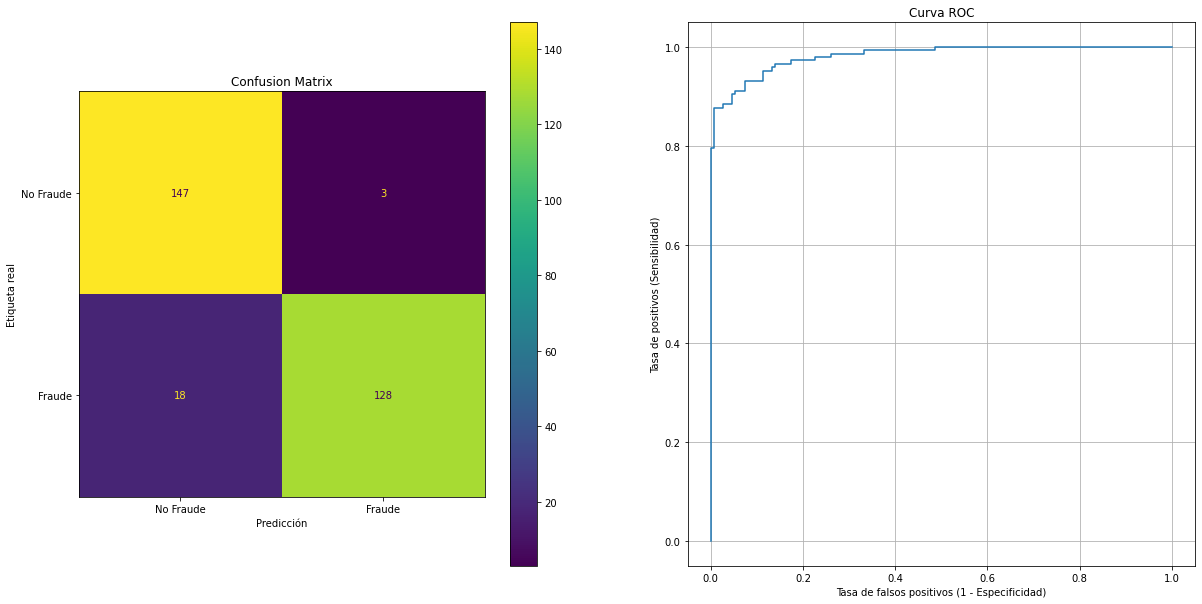

AUC: 0.9821004566210045
Accuracy: 0.9290540540540541
Precision: 0.9770992366412213
Recall: 0.8767123287671232
f1-score:  0.924187725631769


In [21]:
model_metrics_list[ensemble_name]=model_evaluation_report(ensemble_model,y_test,y_pred,y_pred_prob,ensemble_name)

#### 4.2.3.2 Stacking (SKLearn)

Este tipo de ensamble utiliza dos niveles de modelos:
- Los de aprendizaje básico, que generan sus predicciones.
- Un modelo final (meta) que utiliza las predicciones de los modelos anteriores.
La diferencia respecto a la votación, es que en este caso el modelo "meta" asigna un peso al resultado de cada modelo de la etapa anterior.

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

ensemble_name = "Stacking"

ensemble_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
ensemble_model.fit(X_train, y_train)

y_pred = ensemble_model.predict(X_test)
y_pred_prob = ensemble_model.predict_proba(X_test)

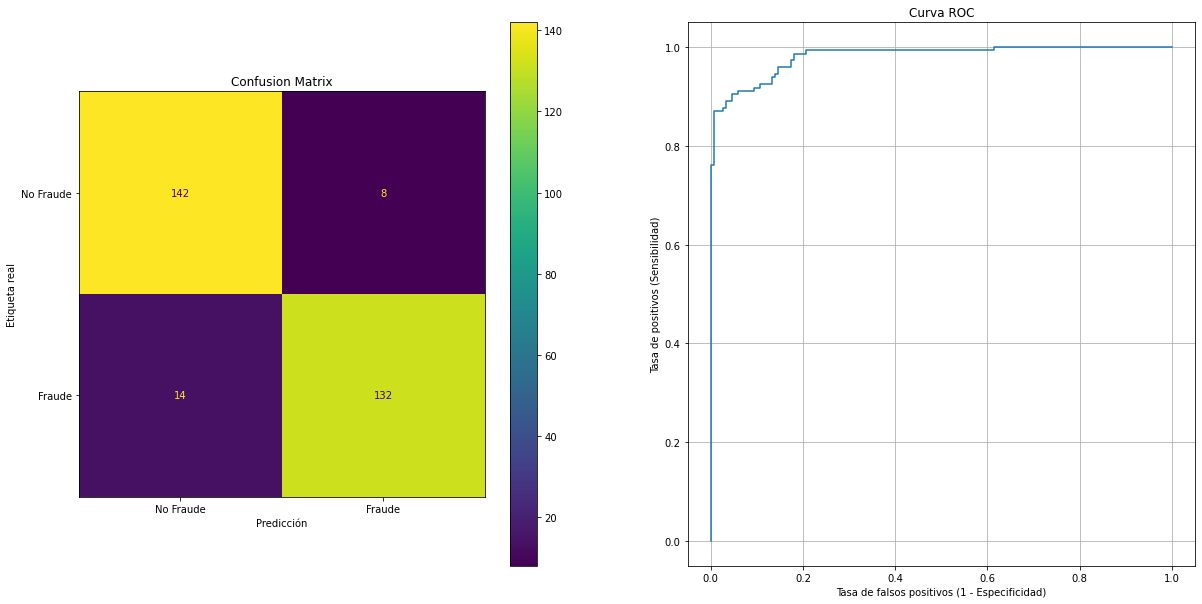

AUC: 0.980958904109589
Accuracy: 0.9256756756756757
Precision: 0.9428571428571428
Recall: 0.9041095890410958
f1-score:  0.923076923076923


In [23]:
model_metrics_list[ensemble_name]=model_evaluation_report(ensemble_model,y_test,y_pred,y_pred_prob,ensemble_name)

#### 4.2.3.3 Stacking (BlendEnsembler de ML-Ensemble)

Se creará otro modelo de Stacking con la librería [ML-Ensemble](http://ml-ensemble.com/).

In [30]:
from mlens.ensemble import BlendEnsemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from mlens.metrics import make_scorer
from sklearn.metrics import roc_auc_score

In [ ]:
ensemble_name = "BlendEnsembler"
auc_scorer = make_scorer(roc_auc_score, average='micro', greater_is_better=True)
ensemble_model = BlendEnsemble(scorer=auc_scorer)
ensemble_model.add([ x[1] for x in estimators ],proba=True,meta=True)
ensemble_model.add_meta(LogisticRegression(),proba=True)
ensemble_model.fit(X_train, y_train)

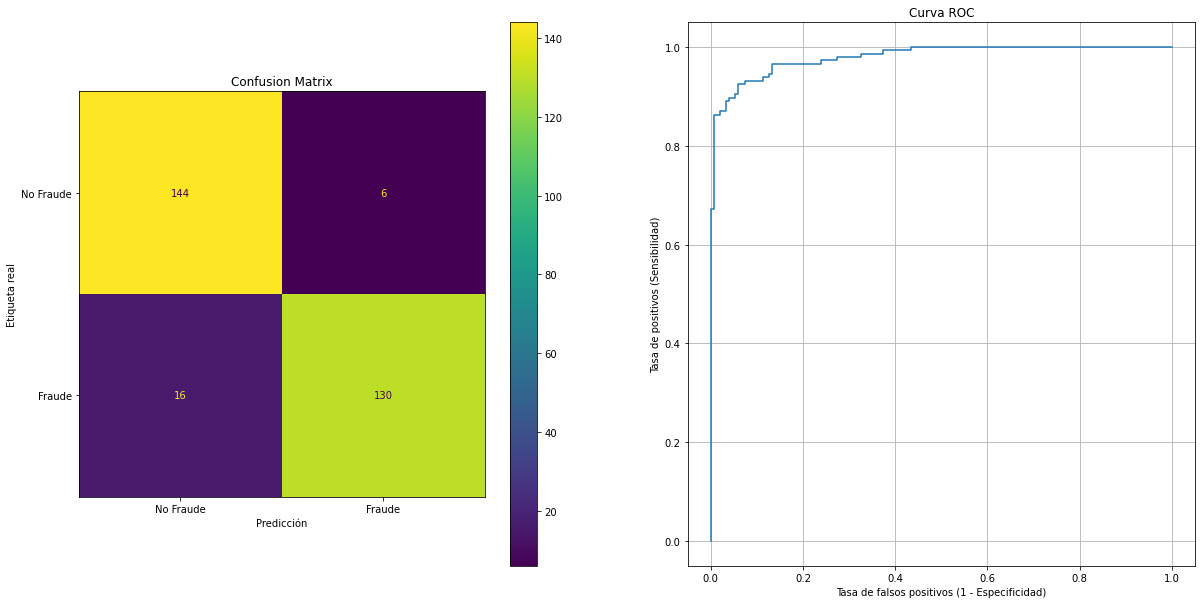

AUC: 0.9798630136986302
Accuracy: 0.9256756756756757
Precision: 0.9558823529411765
Recall: 0.8904109589041096
f1-score:  0.9219858156028369


In [32]:
y_pred_prob = ensemble_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob,axis=1)
model_metrics_list[ensemble_name]=model_evaluation_report(ensemble_model,y_test,y_pred,y_pred_prob,ensemble_name)

## 4.3 Comparación de resultados y conclusiones

A continuación se presentan las métricas para el Test Set de los modelos entrenados.

In [33]:
df = pd.DataFrame.from_dict(model_metrics_list,orient='index')
df.sort_values(by="auc", ascending=False)

,accuracy,precision,recall,auc,f1-score,description
VotingSoft,0.929054,0.977099,0.876712,0.982100,0.924188,VotingSoft
Stacking,0.925676,0.942857,0.904110,0.980959,0.923077,Stacking
BlendEnsembler,0.925676,0.955882,0.890411,0.979863,0.921986,BlendEnsembler


Los resultados obtenidos anteriormente son:

In [34]:
df_models[['accuracy','precision','recall','auc','f1-score']].sort_values(by="auc", ascending=False)

,accuracy,precision,recall,auc,f1-score
name,,,,,
xgboost,0.925676,0.992063,0.856164,0.979452,0.919118
RandomForest,0.925676,0.969697,0.876712,0.976438,0.920863
MLP,0.905405,0.909722,0.897260,0.976210,0.903448
SVM,0.922297,0.976744,0.863014,0.973333,0.916364
DecisionTree,0.902027,0.887417,0.917808,0.965845,0.902357
LogisticRegression,0.908784,0.921986,0.890411,0.964087,0.905923
NearestNeighbors,0.905405,0.953846,0.849315,0.961187,0.898551


Comparativa para selección de modelo final.

In [35]:
df_all = pd.concat([df,df_models],axis=0)
df_all[['accuracy','precision','recall','auc','f1-score']].sort_values(by="auc", ascending=False)

,accuracy,precision,recall,auc,f1-score
VotingSoft,0.929054,0.977099,0.876712,0.982100,0.924188
Stacking,0.925676,0.942857,0.904110,0.980959,0.923077
BlendEnsembler,0.925676,0.955882,0.890411,0.979863,0.921986
xgboost,0.925676,0.992063,0.856164,0.979452,0.919118
RandomForest,0.925676,0.969697,0.876712,0.976438,0.920863
MLP,0.905405,0.909722,0.897260,0.976210,0.903448
SVM,0.922297,0.976744,0.863014,0.973333,0.916364
DecisionTree,0.902027,0.887417,0.917808,0.965845,0.902357
LogisticRegression,0.908784,0.921986,0.890411,0.964087,0.905923
NearestNeighbors,0.905405,0.953846,0.849315,0.961187,0.898551


Se observa que los ensambles (tanto aquellos con Voting y Stacking utilizando modelos anteriores) como los ensambles del cuaderno anterior (XGBoost y Random Forest) presentan resultados significativamente mejores que los modelos individuales.

Se usó la API básica de la librería ML-Ensemble, sin llegar a ensayar otras funciones como selección de modelos y optimización de etapa de preprocesamiento (qué tampoco se hizo para el cuaderno anterior) y tampoco se usaron sus funciones de análisis.

Aún con trabajo pendiente, ya se tiene un modelo que puede ser puesto en producción. 